# Simple VAE on MNIST #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist

In [ ]:
# Load MNIST data
(x_train, _), _ = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28 * 28)

In [ ]:
# Encoder
input_dim = 784
latent_dim = 2

inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(256, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

In [ ]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [ ]:
# Decoder
decoder_h = layers.Dense(256, activation='relu')
decoder_output = layers.Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
outputs = decoder_output(h_decoded)

In [ ]:
# VAE model
vae = Model(inputs, outputs)

# Loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/500
469/469 [==============================] - 1s 2ms/step - loss: 204.4530
Epoch 2/500
469/469 [==============================] - 1s 2ms/step - loss: 170.8320
Epoch 3/500
469/469 [==============================] - 1s 2ms/step - loss: 166.3822
Epoch 4/500
469/469 [==============================] - 1s 2ms/step - loss: 164.2358
Epoch 5/500
469/469 [==============================] - 1s 2ms/step - loss: 162.6385
Epoch 6/500
469/469 [==============================] - 1s 2ms/step - loss: 161.3814
Epoch 7/500
469/469 [==============================] - 1s 2ms/step - loss: 160.3023
Epoch 8/500
469/469 [==============================] - 1s 2ms/step - loss: 159.3142
Epoch 9/500
469/469 [==============================] - 1s 2ms/step - loss: 158.4212
Epoch 10/500
469/469 [==============================] - 1s 2ms/step - loss: 157.6002
Epoch 11/500
469/469 [==============================] - 1s 2ms/step - loss: 156.8420
Epoch 12/500
469/469 [==============================] - 1s 2ms/step - loss

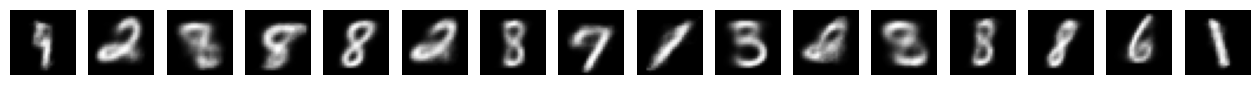

In [ ]:
# Train
vae.fit(x_train, x_train, epochs=50, batch_size=128)

# Create decoder model for generation
decoder_input = layers.Input(shape=(latent_dim,))
_h = decoder_h(decoder_input)
_decoded = decoder_output(_h)
decoder = Model(decoder_input, _decoded)

# Generate new digits
n = 16
z_samples = np.random.normal(size=(n, latent_dim))
generated = decoder.predict(z_samples)
generated = generated.reshape((n, 28, 28))

# Plot generated digits
fig, axes = plt.subplots(1, n, figsize=(16, 2))
for i in range(n):
    axes[i].imshow(generated[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Latent Space Interpolation #
This shows how the model transitions between two different points in the latent space, generating digits that smoothly morph from one to the other.


1/1 [==============================] - 0s 17ms/step


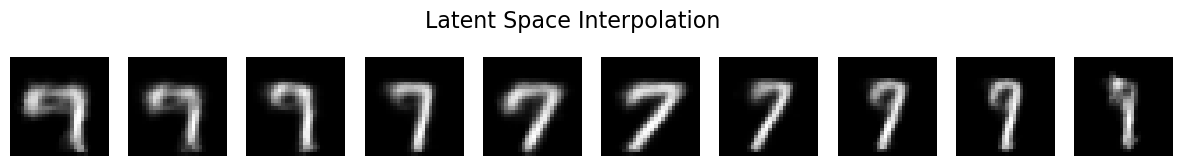

In [3]:
def interpolate(z_start, z_end, num_steps=10):
    vectors = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        z = (1 - alpha) * z_start + alpha * z_end
        vectors.append(z)
    return np.array(vectors)

# Pick two random latent points
z1 = np.random.normal(size=(latent_dim,))
z2 = np.random.normal(size=(latent_dim,))
z_interp = interpolate(z1, z2, num_steps=10)

# Decode and display interpolated digits
generated_interp = decoder.predict(z_interp).reshape(-1, 28, 28)

# Plot
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_interp[i], cmap='gray')
    ax.axis('off')
plt.suptitle("Latent Space Interpolation", fontsize=16)
plt.show()


# Visualizing Latent Space Clusters #
To visualize how different digit classes are organized in the latent space, we need to:

- Build an encoder model.

- Pass test images through the encoder to get their latent vectors.

- Plot these 2D vectors colored by digit label.



79/79 [==============================] - 0s 396us/step


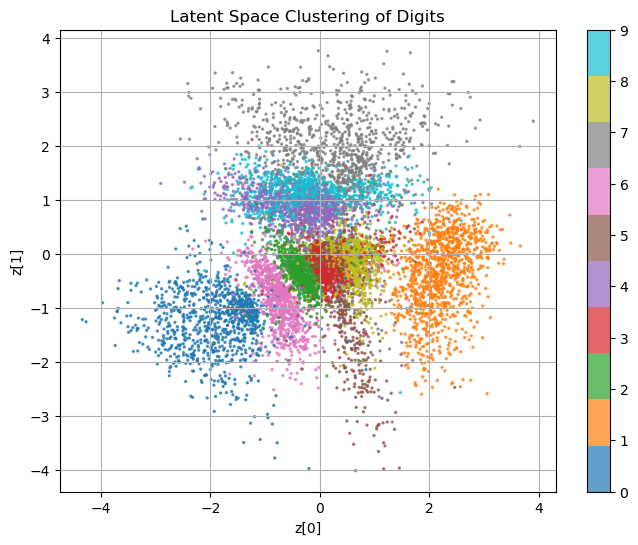

In [4]:
# Load test data with labels
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28)

# Build encoder model
encoder = Model(inputs, z_mean)

# Get latent vectors
z_points = encoder.predict(x_test, batch_size=128)

# Plot using matplotlib
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=y_test, cmap='tab10', alpha=0.7, s=2)
plt.colorbar(scatter, ticks=range(10))
plt.title("Latent Space Clustering of Digits")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()


# Interactive Latent Space Sampler

- Lets us explore the latent space manually by tweaking the z[0] and z[1] values.

- We can see how the digits change gradually and how different areas in latent space correspond to different digit styles.

- We'll notice certain regions produce specific digits or hybrids.

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create sliders for latent dimensions
z1_slider = widgets.FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description='z[0]')
z2_slider = widgets.FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description='z[1]')

output = widgets.Output()

def update_image(change):
    with output:
        clear_output(wait=True)
        z_sample = np.array([[z1_slider.value, z2_slider.value]])
        generated = decoder.predict(z_sample).reshape(28, 28)

        plt.figure(figsize=(2, 2))
        plt.imshow(generated, cmap='gray')
        plt.axis('off')
        plt.title(f"z = [{z1_slider.value:.1f}, {z2_slider.value:.1f}]")
        plt.show()

# Connect sliders to update function
z1_slider.observe(update_image, names='value')
z2_slider.observe(update_image, names='value')

# Initial update
update_image(None)

# Display the interactive widget
display(widgets.VBox([z1_slider, z2_slider]), output)


Output()